In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data= pd.read_csv("/content/drive/MyDrive/Sports Dataset/class_dict.csv")

In [ ]:
data

,class_index,class,height,width,scale by
0,0.0,air hockey,224,224,1
1,1.0,ampute football,224,224,1
2,2.0,archery,224,224,1
3,3.0,arm wrestling,224,224,1
4,4.0,balance beam,224,224,1
...,...,...,...,...,...
229,NaN,NaN,224,224,1
230,NaN,NaN,224,224,1
231,NaN,NaN,224,224,1
232,NaN,NaN,224,224,1


In [ ]:
test = "/content/drive/MyDrive/Sports Dataset/test"
train = "/content/drive/MyDrive/Sports Dataset/train"
valid = "/content/drive/MyDrive/Sports Dataset/valid"

In [ ]:
filepaths_train = list(glob.glob(train+'/**/*.jpg'))
filepaths_test = list(glob.glob(test+'/**/*.jpg'))

In [ ]:
def proc_img(filepath):
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df


In [ ]:
train_df = proc_img(filepaths_train)
test_df = proc_img(filepaths_test)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
train_generator = ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [ ]:
train_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(248, 248),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=0,
subset='training',
rotation_range=30,
zoom_range=0.15,
width_shift_range=1.0,
height_shift_range=1.0,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest"
)
val_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(248, 248),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=0,
subset='validation',
rotation_range=30,
zoom_range=0.15,
width_shift_range=1.0,
height_shift_range=1.0,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest"
)
test_images = test_generator.flow_from_dataframe(
dataframe=test_df,
x_col='Filepath',
y_col='Label',
target_size=(248, 248),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False
)

Found 8352 validated image filenames belonging to 73 classes.
Found 2087 validated image filenames belonging to 73 classes.
Found 365 validated image filenames belonging to 73 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
pretrained_model.trainable = False
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(73, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)

In [ ]:
ACCURACY_THRESHOLD = 1
from keras.callbacks import Callback
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
      print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()
history = model.fit(
train_images,
validation_data=val_images,
epochs=7,
callbacks=[callbacks]
)

Epoch 1/7
261/261 [==============================] - 2956s 11s/step - loss: 1.7497 - accuracy: 0.5650 - val_loss: 0.7750 - val_accuracy: 0.7710
Epoch 2/7
261/261 [==============================] - 299s 1s/step - loss: 0.4944 - accuracy: 0.8580 - val_loss: 0.6679 - val_accuracy: 0.8016
Epoch 3/7
261/261 [==============================] - 296s 1s/step - loss: 0.2847 - accuracy: 0.9162 - val_loss: 0.5107 - val_accuracy: 0.8476
Epoch 4/7
261/261 [==============================] - 294s 1s/step - loss: 0.1687 - accuracy: 0.9526 - val_loss: 0.5665 - val_accuracy: 0.8318
Epoch 5/7
261/261 [==============================] - 296s 1s/step - loss: 0.1168 - accuracy: 0.9676 - val_loss: 0.5356 - val_accuracy: 0.8548
Epoch 6/7
261/261 [==============================] - 296s 1s/step - loss: 0.0720 - accuracy: 0.9822 - val_loss: 0.5236 - val_accuracy: 0.8586
Epoch 7/7
261/261 [==============================] - 292s 1s/step - loss: 0.0431 - accuracy: 0.9911 - val_loss: 0.5597 - val_accuracy: 0.8433


In [ ]:
results = model.evaluate(test_images, verbose=0)
print(" Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


 Test Loss: 0.19537
Test Accuracy: 92.33%


NameError: ignored

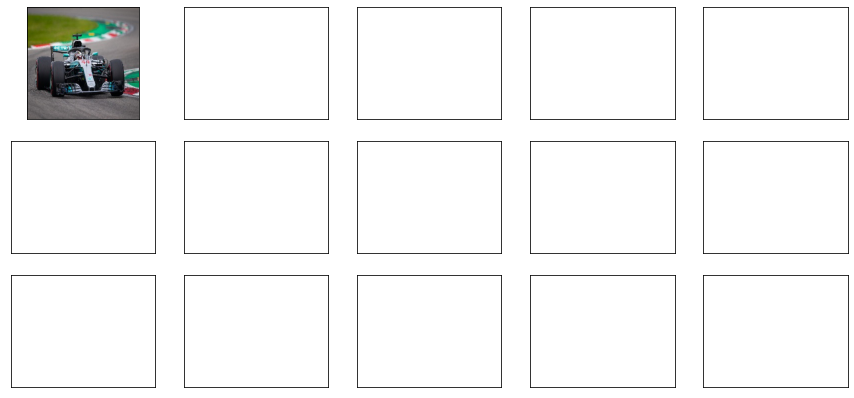

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()